## Rewriting some parts of qiskit nature package

In [1]:
from qiskit_nature.problems.sampling.protein_folding.peptide.peptide import Peptide
from qiskit_nature.problems.sampling.protein_folding.penalty_parameters import PenaltyParameters
from qiskit_nature.problems.sampling.protein_folding.protein_folding_problem import ProteinFoldingProblem
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit import execute, Aer
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit.algorithms import VQE
from qiskit.utils import algorithm_globals, QuantumInstance
algorithm_globals.random_seed = 23

In [2]:
### 1. Defining a protein

main_chain = "APRLRFY" #Alanine,Proline,Arginine,Leucine,Arginine,Phenylalanine,Tyrosine / 7 amino acids
chain_len = len(main_chain)
side_chains = [""] * chain_len # seven empty side chains = no side chains

def validate_main_chain(main_chain: str):
    for amino_acid in main_chain:
        if validate_amino_acid(amino_acid) == False:
            return False
    return True

def validate_amino_acid(amino_acid: str) -> bool:
    valid_amino_acids = [
        "A",  # Alanine
        "C",  # Cysteine
        "D",  # Aspartic acid
        "E",  # Glutamic acid
        "F",  # Phenylalanine
        "G",  # Glycine
        "H",  # Histidine
        "I",  # Isoleucine
        "K",  # Lysine
        "L",  # Leucine
        "M",  # Methionine
        "N",  # Asparagine
        "P",  # Proline
        "Q",  # Glutamine
        "R",  # Arginine
        "S",  # Serine
        "T",  # Threonine
        "V",  # Valine
        "W",  # Tryptophan
        "Y",  # Tyrosine
    ]
    if amino_acid != "" and amino_acid not in valid_amino_acids:
        return False
    return True

print("validate the main chain:",validate_main_chain(main_chain))
protein1 = Peptide(main_chain, side_chains)

validate the main chain: True


In [3]:
### 2. The interaction method

from pathlib import Path
import os
import numpy as np
from typing import Tuple, List

def path_of_file(a:str):
    path1 = Path().parent.absolute()
    path2 = Path("resources")
    path1 = os.path.join(path1, path2)
    filename = a +"_matrix.txt"
    path = os.path.normpath(os.path.join(path1, filename))
    return path

def load_matrix(a) -> Tuple[np.ndarray, List[str]]:
    path = path_of_file(a)
    matrix = np.loadtxt(fname=path, dtype=str)
    matrix2 = np.zeros((np.shape(matrix)[0], np.shape(matrix)[1]))
    for row in range(1, np.shape(matrix)[0]):
        for col in range(row - 1, np.shape(matrix)[1]):
            matrix2[row, col] = float(matrix[row, col])
    matrix2 = matrix2[1:,]
    amino_acids = list(matrix[0, :])
    return matrix2, amino_acids

class MiyazawaJerniganInteraction():
    def calculate_energy_matrix(self, main_chain: str) -> np.ndarray:
            chain_len = len(main_chain)
            mj_matrix, list_amino_acids = load_matrix('mj') 
            energy_matrix = np.zeros((chain_len + 1, 2, chain_len + 1, 2)) 
            for i in range(1, chain_len + 1):
                for j in range(i + 1, chain_len + 1):
                    aa_i = list_amino_acids.index(main_chain[i - 1])
                    aa_j = list_amino_acids.index(main_chain[j - 1])
                    energy_matrix[i, 0, j, 0] = mj_matrix[min(aa_i, aa_j), max(aa_i, aa_j)] 
            return energy_matrix

miyazawa_jernigan = MiyazawaJerniganInteraction()

<AxesSubplot:>

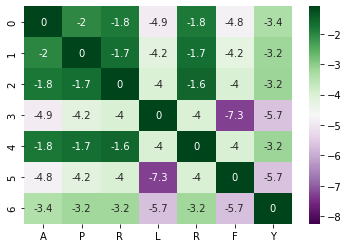

In [4]:
energy_matrix1 = miyazawa_jernigan.calculate_energy_matrix(main_chain)
energy_matrix2 = np.zeros((chain_len, chain_len))
for i in range(chain_len):
    for j in range(chain_len):
        energy_matrix2[i][j] = energy_matrix1[i + 1, 0, j + 1, 0]

energy_matrix3 = energy_matrix2        
for i in range(chain_len):
    for j in range(chain_len):
        if(energy_matrix3[j][i] == 0):
            energy_matrix3[j][i] = round(energy_matrix1[i + 1, 0, j + 1, 0],1)
            
#seaborn.heatmap
import seaborn
import pandas as pd
import numpy as np

columns=[]
for i in range(chain_len):
    columns.append(main_chain[i])

df = pd.DataFrame(data=energy_matrix2, columns=columns)

#cmap: matplotlib colormap name
seaborn.heatmap(df, annot=True, cmap="PRGn", vmin=-1.1, vmax=-7.5, annot_kws={"size": 10}) 

In [5]:
### 3. Penalty terms
penalty_terms = PenaltyParameters(10,10,10) #(penalty_chiral, penalty_back, penalty_1)

### using ProteinFoldingProblem Function
protein_folding_1 = ProteinFoldingProblem(protein1, miyazawa_jernigan, penalty_terms)
qubit_operations_1 = protein_folding_1.qubit_op()
print(qubit_operations_1)

1613.5895000000003 * IIIIIIIII
+ 487.5 * IIIIIIZII
- 192.5 * IIIIIIIZZ
+ 192.5 * IIIIIIZZZ
- 195.0 * IIIIZIZII
- 195.0 * IIIIIZIZI
- 195.0 * IIIIZZZZI
- 95.0 * IIZIZIIII
- 95.0 * IIIZIZIII
- 95.0 * IIZZZZIII
+ 295.0 * IIIIIIZZI
- 497.5 * IIIIZIIII
- 300.0 * IIIIZZIII
+ 195.0 * IIIIIIIIZ
+ 197.5 * IIIIIZIIZ
- 197.5 * IIIIZZIIZ
- 904.2875 * IZIIIIIII
- 295.0 * IZIIIIZII
- 197.5 * IZIIIIZZI
+ 302.5 * IZIIZIIII
+ 202.5 * IZIIZZIII
+ 100.0 * IZIIZIZII
+ 100.0 * IZIIIZIZI
+ 100.0 * IZIIZZZZI
- 200.0 * IZIIIIIIZ
+ 97.5 * IZIIIIIZZ
- 97.5 * IZIIIIZZZ
- 100.0 * IZIIIZIIZ
+ 100.0 * IZIIZZIIZ
+ 100.0 * IIIIIIIZI
- 100.0 * IIIIIZIII
+ 2.5 * IZIIIIIZI
- 2.5 * IZIIIZIII
+ 192.5 * IIZIIIIII
+ 95.0 * IIZZIIIII
+ 97.5 * IIZIIIZII
+ 97.5 * IIIZIIIZI
+ 97.5 * IIZZIIZZI
- 97.5 * IIIZIIIIZ
+ 97.5 * IIZZIIIIZ
+ 7.5 * IZZIIIIII
+ 5.0 * IZZZIIIII
+ 2.5 * IZZIIIZII
+ 2.5 * IZIZIIIZI
+ 2.5 * IZZZIIZZI
- 2.5 * IZZIZIIII
- 2.5 * IZIZIZIII
- 2.5 * IZZZZZIII
- 2.5 * IZIZIIIIZ
+ 2.5 * IZZZIIIIZ
+ 105.0 * IIIZIIIII
-

In [6]:
### 1. ansatz
ansatz = RealAmplitudes(reps=1)

### 2. optimizer
optimizer = COBYLA(maxiter=50)

### 3. backend
backend = "aer_simulator"
backend = QuantumInstance(
    Aer.get_backend(backend),
    shots=8192,
    seed_transpiler=algorithm_globals.random_seed,
    seed_simulator=algorithm_globals.random_seed,
)

### callback function
counts = []
values = []

def callback_function(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    
    
### expectation
cvar_exp = CVaRExpectation(0.1, PauliExpectation())

### VQE using CVaR
vqe = VQE(
    expectation=cvar_exp,
    optimizer=optimizer,
    ansatz=ansatz,
    quantum_instance=backend,
    callback=callback_function,
)

result = vqe.compute_minimum_eigenvalue(qubit_operations_1)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 50,
    'eigenstate': {   '000000000': 0.015625,
                      '000000001': 0.046875,
                      '000000010': 0.03314563036811941,
                      '000000011': 0.06346905003621844,
                      '000000101': 0.04941058844013093,
                      '000000110': 0.015625,
                      '000000111': 0.02209708691207961,
                      '000001001': 0.029231698334171417,
                      '000001010': 0.019136638615493577,
                      '000001011': 0.04555431167847891,
                      '000001101': 0.029231698334171417,
                      '000010001': 0.015625,
                      '000010011': 0.027063293868263706,
                      '000010101': 0.02209708691207961,
                      '000010111': 0.011048543456039806,
                      '000011000': 0.02209708691207961,
                      '000011001': 0.06051536478449089,
                  

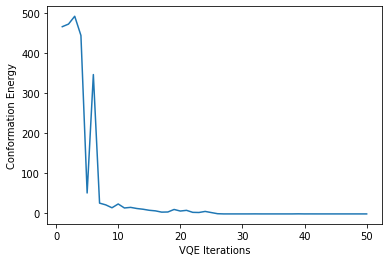

In [7]:
import matplotlib.pyplot as plt

figure = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")

plt.show()

In [8]:
result2 = protein_folding_1.interpret(raw_result=result)
print(f"The folded protein's main sequence of turns is: {result2.protein_shape_decoder.main_turns}")
print(f"and the side turn sequences are: {result2.protein_shape_decoder.side_turns}")

The folded protein's main sequence of turns is: [1, 0, 3, 2, 0, 3]
and the side turn sequences are: [None, None, None, None, None, None, None]


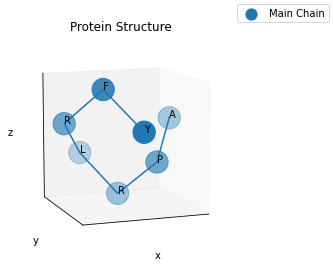

In [9]:
fig = result2.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)